In [1]:
import ee
ee.Initialize()

import geojson
from shapely import geometry
import pandas as pd
import geopandas as gpd

from eSBAE import hexagonal_grid, plot_samples
from eSBAE import landsat_collection, extract_time_series

/home/sepal-user/venv/eSBAE/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [ ]:
aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Beni'))
cells, points = hexagonal_grid(aoi, 7)
plot_samples(aoi, points, cells)

In [ ]:
import eSBAE

In [ ]:
# re-create a dataframe
d = {
    'dates': [['2022-10-10','2022-11-10','2023-01-01','2023-04-01']],
    'ts': [{
        'red': [543.34, 363.42, 6456.4, 345],
        'ndfi': [54.34, 36.42, 645.4, 35]
    }],
    'geometry': [geometry.Point(0, 0)]
}

df = pd.DataFrame.from_dict(d, orient='columns')
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
# this is how we dump
with open('test.geojson', 'w') as outfile:
     geojson.dump(gdf.to_json(), outfile)

In [ ]:
# this is how we load
with open('test.geojson', 'r') as outfile:
    d = gpd.GeoDataFrame.from_features(geojson.loads(geojson.load(outfile)))

In [ ]:
# alternative, needs pyarrow
d.to_parquet('test.parquet')

In [2]:
grid = gpd.read_file('/home/sepal-user/Ethiopia/grids/fine_grid_points_biomes_res15_esri54017.gpkg')


In [ ]:
import dask_geopandas

partitions = int(len(grid)/200)
print(partitions)
d_gdf = dask_geopandas.from_geopandas(grid, npartitions=4)
# create hilbert curve and sort by distance

grid['hilbert_distance'] = d_gdf.geometry.hilbert_distance()
grid = grid.sort_values('hilbert_distance').reset_index()

In [ ]:
grid.head(200)

In [ ]:
#d_gdf.calculate_spatial_partitions() # convex hull
geohash = d_gdf.spatial_shuffle(by="hilbert")
geohash.spatial_partitions.plot(cmap="tab20", alpha=0.1, figsize=(20,20))


In [3]:
gdf = grid.tail(20)
gdf['point_id'] = gdf.index
geo_json = gdf[['point_id', 'geometry']].to_crs('epsg:4326').to_json()
fc = ee.FeatureCollection(json.loads(geo_json))

/home/sepal-user/venv/eSBAE/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
point_id_name = 'point_id'
# start of calibration period (mainly for bfast)
start_calibration = "2015-01-01"  # YYYY-MM-DD format

# Actual period of interest, i.e. monitoring period
start_monitor =     "2016-01-01"  # YYYY-MM-DD format
end_monitor =       "2017-01-01"  # YYYY-MM-DD format

# Directory where output and temp files will go
outdir = 'results'  # goes to module_results/sbae_point_analysis if set to None

# Select algorithms to run (Treu or False)
cusum_deforest =  True
bfast_monitor =   True
bs_slope =        True
ts_metrics =      True
ccdc =            True
landtrendr =      True
jrc_nrt =         True
global_products = True

# select the bands to extract
bands = ['green', 'red', 'nir', 'swir1', 'swir2', 'ndfi'] # other choices: ndfi, ndmi, mndwi, brightness, greenness, wetness

# select the band for univariate ts-analysis (has to be inside bands list)
ts_band = 'ndfi'

# select the resolution to which the satellite data will be resized.
scale = 70  # in meters (70 m is half ha, relates to FAO forest definition)

### DO NOT CHANGE YET ###
satellite='Landsat'  # this is going to be Surface Reflactance, Collection 2, Tier 1 data only
max_cloud_cover = 75  # in percentage (0-100)

# landsat related parameters
lsat_params = {
    'l9':     True,
    'l8':     True,
    'l7':     True,
    'l5':     True,
    'l4':     True,
    'brdf':   True,
    'bands':  bands,
    'max_cc': max_cloud_cover
}

# bfast parameters
bfast_params = {
    'run':           bfast_monitor,
    'start_monitor': start_monitor, 
    'freq':          365,
    'k':             3, 
    'hfrac':         0.25, 
    'trend':         True, 
    'level':         0.05, 
    'backend':       'python'
}

# cusum parameters
cusum_params = {
    'run':              cusum_deforest,
    'nr_of_bootstraps': 1000
}

# slope parameters
bs_slope_params = {
    'run':              bs_slope,
    'nr_of_bootstraps': 1000
}

# time-series metrics
ts_metrics_params = {
    'run':              ts_metrics,
    'outlier_removal':  False,
    'z_threshhold':     3
}

# ccdc parameters
ccdc_params = {
    'run':                   ccdc,
    'breakpointBands':       ['green', 'red', 'nir', 'swir1', 'swir2'],
    'tmaskBands':            ['green', 'swir2'],
    'minObservations':       6,
    'chiSquareProbability':  .99,
    'minNumOfYearsScaler':   1,
    'dateFormat':            2,
    'lambda':                20,
    'maxIterations':         1000
}


landtrendr_params = { 
        'run':                    landtrendr,
        'maxSegments':            6,
        'spikeThreshold':         0.9,
        'vertexCountOvershoot':   3,
        'preventOneYearRecovery': True,
        'recoveryThreshold':      0.25,
        'pvalThreshold':          0.05,
        'bestModelProportion':    0.75,
        'minObservationsNeeded':  3
}

jrc_nrt_params = {
    'run': jrc_nrt
}

# global products parameters
global_products = {
    'run':                      global_products,
    'gfc':                      True,     # will include tree-cover 2000, loss, gain, lossyear
    'tmf':                      True,    # will include deforestation and degradation year for tropical moist forests
    'tmf_years':                True,    # will include classes per year - according to the monitor period
    'esa_lc20':                 True,    # will include ESA LandCover Product class
    'copernicus_lc':            True,    # will include ESA LandCover Product class - acording to the monitoring years
    'esri_lc':                  True,    # will include the classes from ESRI World Cover 2020
    'lang_tree_height':         True,    # returns the Tree Height from Lang et al 2022
    'potapov_tree_height':      True,    # returns the tree height from Potapov et al. 2019 
    'elevation':                True,    # returns elevation, slope and aspect
    'dynamic_world_tree_prob':  True,    # returns Min, Max, Mean and StdDev of the trees probability for the monitoring period
    'dynamic_world_class_mode': True     # returns the mode of the class for the monitoring period   
}

### DO NOT CHANGE ###
### GATHER ALL INFO INTO A DICT #####
config_dict = {
    'work_dir':                         outdir,
    'workers':                          10,
    'max_points_per_chunk':             250,
    'grid_size_levels':                 [4, 2, 1, 0.5, 0.25, 0.125, 0.075],  # definition of chunk sizes in degrees  
    'lsat_params':                      lsat_params,
    'ts_params': {
        'start_calibration':            start_calibration,
        'start_monitor':                start_monitor,
        'end_monitor':                  end_monitor,
        'point_id':                     point_id_name,
        'bands':                        bands,
        'ts_band':                      ts_band,
        'satellite':                    satellite,
        'scale':                        scale,
        'max_cc':                       max_cloud_cover,
        'outlier_removal':              True,
        'smooth_ts':                    True       
    },    
    'bfast_params':                     bfast_params,
    'cusum_params':                     cusum_params,
    'bs_slope_params':                  bs_slope_params,
    'ts_metrics_params':                ts_metrics_params,
    'ccdc_params':                      ccdc_params,
    'landtrendr_params':                landtrendr_params,
    'jrc_nrt_params':                   jrc_nrt_params,
    'global_products':                  global_products
}

In [5]:
# create image collection (not being changed)
lsat = landsat_collection(
    start_calibration, 
    end_monitor, 
    fc.geometry().convexHull(100), 
    **config_dict['lsat_params']
)
extr_df = extract_time_series(lsat, fc, config_dict)

In [11]:
extr_df.to_file('test.gpkg', driver='GPKG')

ValueError: Invalid field type <class 'list'>

In [ ]:
def structure_ts_data(df, point_id_name, bands):
    
    
    df.index = pd.DatetimeIndex(pd.to_datetime(df.imageID.apply(lambda x: x.split('_')[-1]), format='%Y%m%d'))
    df['dates'] = df['imageID'].apply(lambda x: int(x.split('_')[-1]))
    #print(df['dates'])
    #return
    # loop over point_ids and run cusum
    d = {}
    for i, point in enumerate(df[point_id_name].unique()):
        
        # read only orws of points and sort by date
        sub = df[df[point_id_name] == point].sort_index()
        
        #### LANDSAT ONLY ###########
        sub['pathrow'] = sub.imageID.apply(lambda x: x.split('_')[-2])

        # if more than one path row combination covers the point, we select only the one with the most images
        if len(sub.pathrow.unique()) > 1:
            # set an initil length
            length = -1
            # loop through pathrw combinations
            for pathrow in sub.pathrow.unique():
                # check length
                l = len(sub[sub.pathrow == pathrow])
                # compare ot previous length, and if higher reset pathrow and length variable
                if l > length:
                    pr = pathrow
                    length = l
            # finally filter sub df for pathrow with most images
            sub = sub[sub.pathrow == pr]
        #### LANDSAT ONLY ###########
        
        # still duplicates may appear between l9 and l8 that would make bfast crash, so we drop
        sub = sub[~sub.index.duplicated(keep='first')]
        
        # fill ts dictionary
        ts_dict= {}
        for band in bands:
            ts_dict.update({band: sub[band].tolist()})
        
        # write everything to a dict
        d[i] = {
            'point_idx': i,
             point_id_name: point,
            'dates': sub['dates'].tolist(),
            'ts': ts_dict, 
            'images': len(sub),
            'geometry': sub.geometry.head(1).values[0]
        }
    
    # turn the dict into a geodataframe and return
    return gpd.GeoDataFrame(pd.DataFrame.from_dict(d, orient='index')).set_geometry('geometry')

In [ ]:
new = structure_ts_data(extr_df, point_id_name, bands)

In [ ]:
new.head(1).ts[0]['red']

In [23]:
from scipy import stats
import math

# Test that both populations have the same proportion.
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

# Sample calculator
def sample_required(p1, p_diff, alpha):
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

sample_required(0.2, 0.05, 300000)

1

In [75]:
z_score = 1.645
country_area = 50000000
change_area = 50000
proportion_change = change_area/country_area
error = 0.2 * proportion_change
print(proportion_change*country_area)

50000.0


112683.39104166665

In [89]:
def calculate_sample_size_cochran(total_area, subarea, z_score=1.645, target_precision=0.2):
    
    proportional_change = subarea/total_area
    error = target_precision * proportional_change
    return (z_score*z_score * proportional_change * (1 - proportional_change))/(error*error)


def calculate_sample_size_yamane(total_area, subarea, z_score=1.645, target_precision=0.2):
    
    proportional_change = subarea/total_area
    error = target_precision * proportional_change
    return total_area / (1 + total_area * (error*error))


cochran = calculate_sample_size_cochran(
    total_area = 58036700,
    subarea = 50000,
    z_score=1.645,
    target_precision=.2
)


yamane = calculate_sample_size_yamane(
    total_area = 58036700,
    subarea = 50000,
    z_score=1.645,
    target_precision=.5
)

print(cochran, yamane)

78456.72993374997 4931299.51419887


In [98]:
import numpy as np
# we should invert that to do something similar as extrating from global data
def calculate_error_cochran(total_area, subarea, z_score=1.645, sample_size=250):
    
    proportional_change = subarea/total_area
    return np.sqrt((z_score*z_score * proportional_change * (1 - proportional_change))/sample_size)/proportional_change

In [158]:
d = {}
for idx, sample_size in enumerate(range(10000, 500000, 10000)):
    error = calculate_error_cochran(total_area = 158036700,
        subarea = 40000,
        z_score=1.645,
        sample_size=sample_size)*100
    grid_size = np.sqrt(58036700/100/sample_size)
    d[idx] = sample_size, error, grid_size
    
    
df = pd.DataFrame.from_dict(d, orient='index')

display(df)
df.columns = ['Sample Size', 'Error', 'Grid Size']

,0,1,2
0,10000,103.385567,7.618182
1,20000,73.104636,5.386868
2,30000,59.689685,4.398360
3,40000,51.692784,3.809091
4,50000,46.235431,3.406955
5,60000,42.206981,3.110110
6,70000,39.076071,2.879402
7,80000,36.552318,2.693434
8,90000,34.461856,2.539394
9,100000,32.693387,2.409081


<Axes: xlabel='Grid Size', ylabel='Sample Size'>

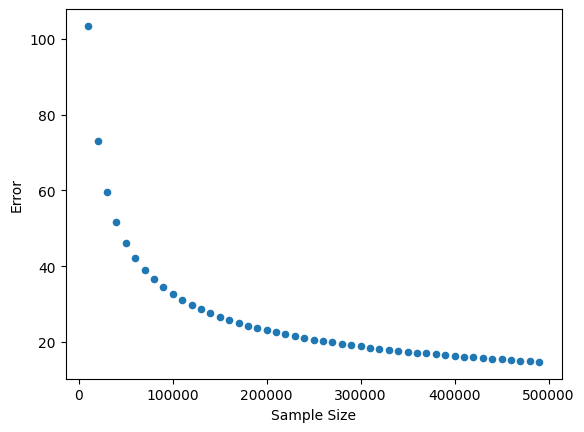

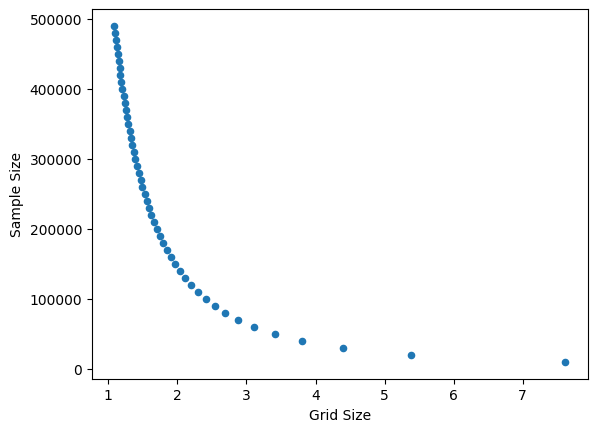

In [159]:
df.plot(kind='scatter', y='Error', x='Sample Size')
df.plot(kind='scatter', y='Sample Size', x='Grid Size')

1.3908834123199063